# Table of Contents
 <p><div class="lev1"><a href="#Simulate-locations"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simulate locations</a></div><div class="lev1"><a href="#Simulate-data-from-GP"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulate data from GP</a></div><div class="lev1"><a href="#Inference"><span class="toc-item-num">3&nbsp;&nbsp;</span>Inference</a></div><div class="lev1"><a href="#Estimate-mean-treatment-effect"><span class="toc-item-num">4&nbsp;&nbsp;</span>Estimate mean treatment effect</a></div><div class="lev2"><a href="#Distance-averaged-treatment-effect"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Distance-averaged treatment effect</a></div><div class="lev2"><a href="#Inverse-variance-weighted-treatment-effect"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Inverse-variance weighted treatment effect</a></div><div class="lev1"><a href="#Simulate-under-the-null"><span class="toc-item-num">5&nbsp;&nbsp;</span>Simulate under the null</a></div><div class="lev1"><a href="#Power-under-an-alternative"><span class="toc-item-num">6&nbsp;&nbsp;</span>Power under an alternative</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\below}{\unicode{x25E7}}
    \newcommand{\above}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jbelow}{\unicode{x21E5}}
    \newcommand{\jabove}{\unicode{x21E4}}
$$

In [93]:
using LaTeXStrings
using GaussianProcesses
using Distributions
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Simulate locations

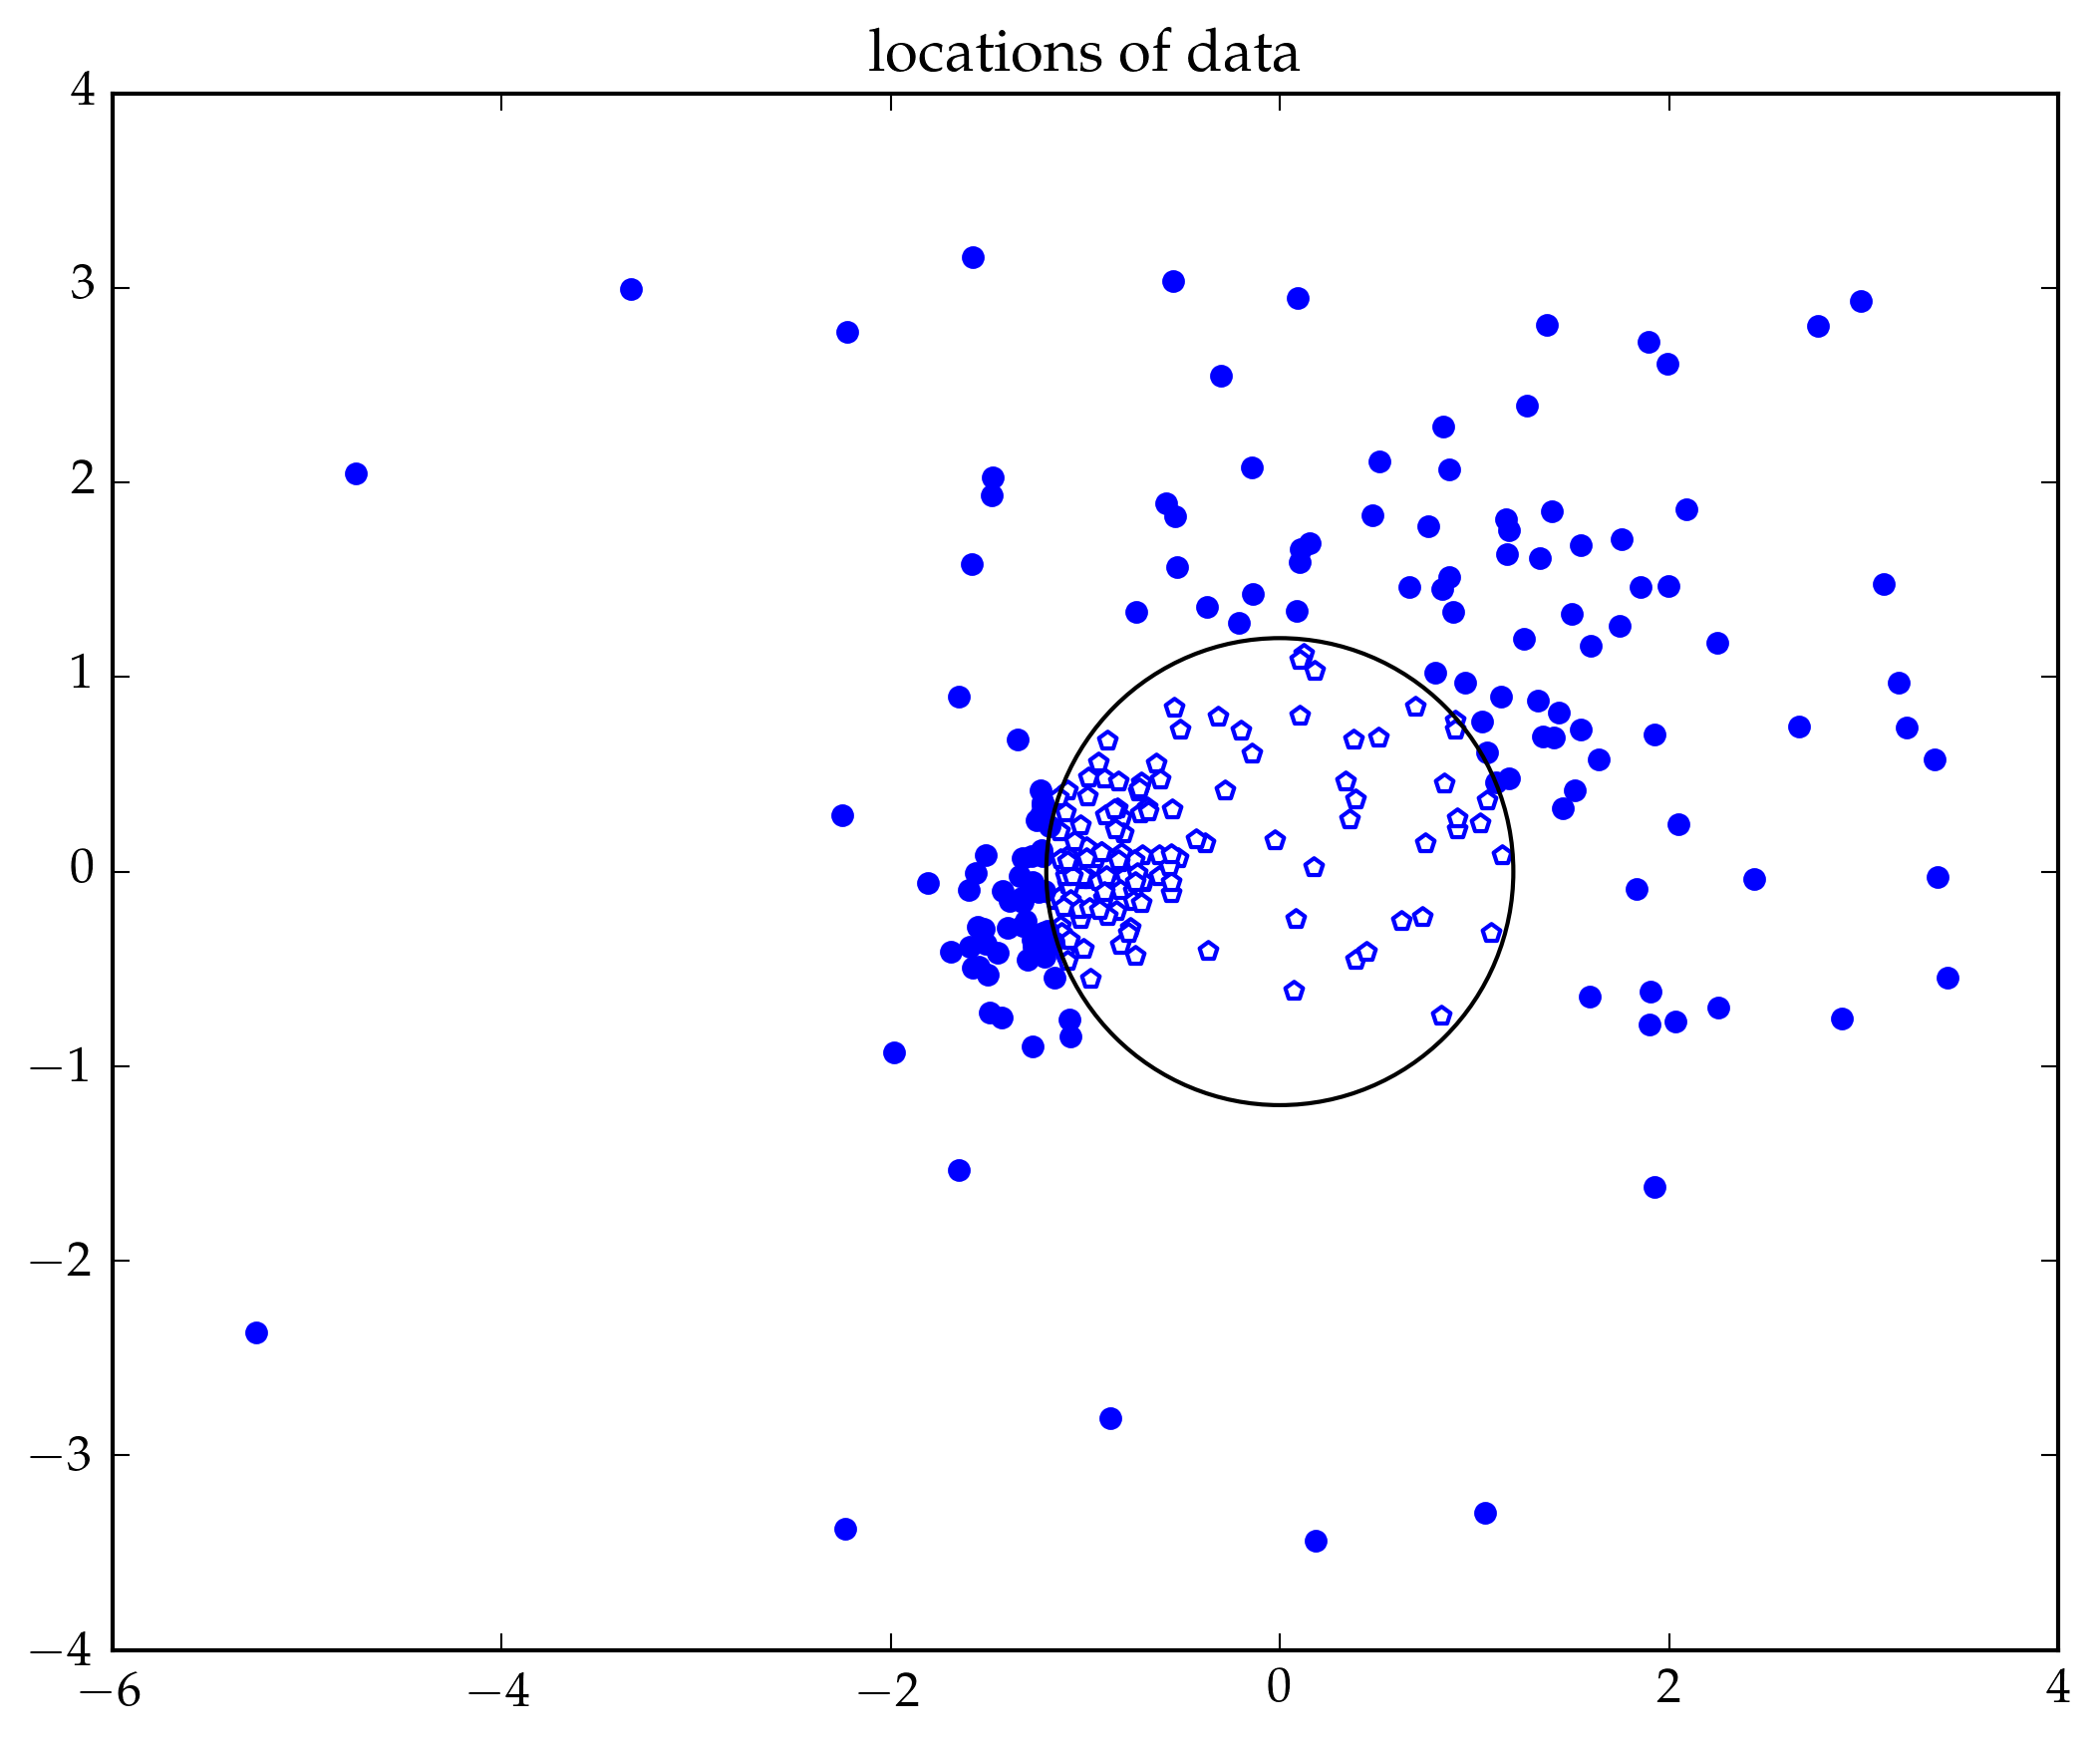

In [94]:
city = MultivariateNormal([-1.0,0.0], [[0.1,0.05] [0.05, 0.1]])
village = MultivariateNormal([1.0,1.0], [[1.0,-0.5] [-0.5, 1.0]])
countryside = MultivariateNormal([0.0, 0.0], [[4.0,0.0] [0.0, 4.0]])
X=[rand(city, 150) rand(village, 100) rand(countryside, 30)]
_,n = size(X)
r◫ = 1.2
inside = vec((X[1,:].^2 .+ X[2,:].^2) .< r◫^2)
plt.scatter(X[1,inside],X[2,inside], color="white", edgecolor="blue", marker="p")
plt.scatter(X[1,!inside],X[2,!inside], color="blue")
circle=plt.plt[:Circle]((0,0),r◫,color="black", fill=false)
plt.gca()[:add_artist](circle)
plt.gca()[:set_aspect]("equal")
plt.title("locations of data");

# Simulate data from GP

In [95]:
Lstar=1.0
σf_star=2.0
σy2_star=0.5
kern = SE(log(Lstar), log(σf_star))

Type: GaussianProcesses.SEIso, Params: [0.0,0.6931471805599453]


In [96]:
Σprior=GaussianProcesses.crossKern(X, kern)
μprior=zeros(n)
Σobs=copy(Σprior)
for i in 1:n
    Σobs[i,i] += σy2_star
end
prior=MultivariateNormal(μprior,Σobs)
Y=rand(prior)
;

In [97]:
α◫ = linspace(0,2π,100)
x1◫ = cos(α◫)*r◫
x2◫ = sin(α◫)*r◫
X◫ = [x1◫ x2◫]'
size(X◫)

(2,100)

# Inference

In [98]:
gp_fit_inside = GP(X[:,inside], Y[inside], MeanZero(), kern, log(σy2_star))
gp_fit_outside = GP(X[:,!inside], Y[!inside], MeanZero(), kern, log(σy2_star))
;

In [99]:
extrap◫_inside = predict(gp_fit_inside, X◫; full_cov=true)
extrap◫_outside = predict(gp_fit_outside, X◫; full_cov=true)

([3.95187,3.82906,3.68145,3.51064,3.31812,3.10522,2.87295,2.62213,2.35339,2.06729  …  3.82026,3.93722,4.03305,4.10491,4.15053,4.16827,4.1572,4.11707,4.04832,3.95187],
100x100 Array{Float64,2}:
 0.257109   0.235747   0.213446   …  0.295373   0.277106   0.257109 
 0.235747   0.218093   0.199291      0.266239   0.251895   0.235747 
 0.213446   0.199291   0.183891      0.236926   0.226067   0.213446 
 0.190669   0.17975    0.167589      0.20796    0.200127   0.190669 
 0.167898   0.159906   0.150761      0.179852   0.174582   0.167898 
 0.145606   0.1402     0.133798   …  0.153076   0.149918   0.145606 
 0.124236   0.121056   0.117086      0.128047   0.126575   0.124236 
 0.104178   0.102858   0.100983      0.105104   0.104927   0.104178 
 0.0857499  0.0859305  0.0858034     0.0844948  0.0852683  0.0857499
 0.0691867  0.0705278  0.0718035     0.0663725  0.0677983  0.0691867
 0.0546345  0.056824   0.0591719  …  0.0507928  0.0526229  0.0546345
 0.0421504  0.0449115  0.0480265     0.0377204  

In [100]:
μpost = extrap◫_inside[1].-extrap◫_outside[1]
Σpost = extrap◫_inside[2]+extrap◫_outside[2]
;

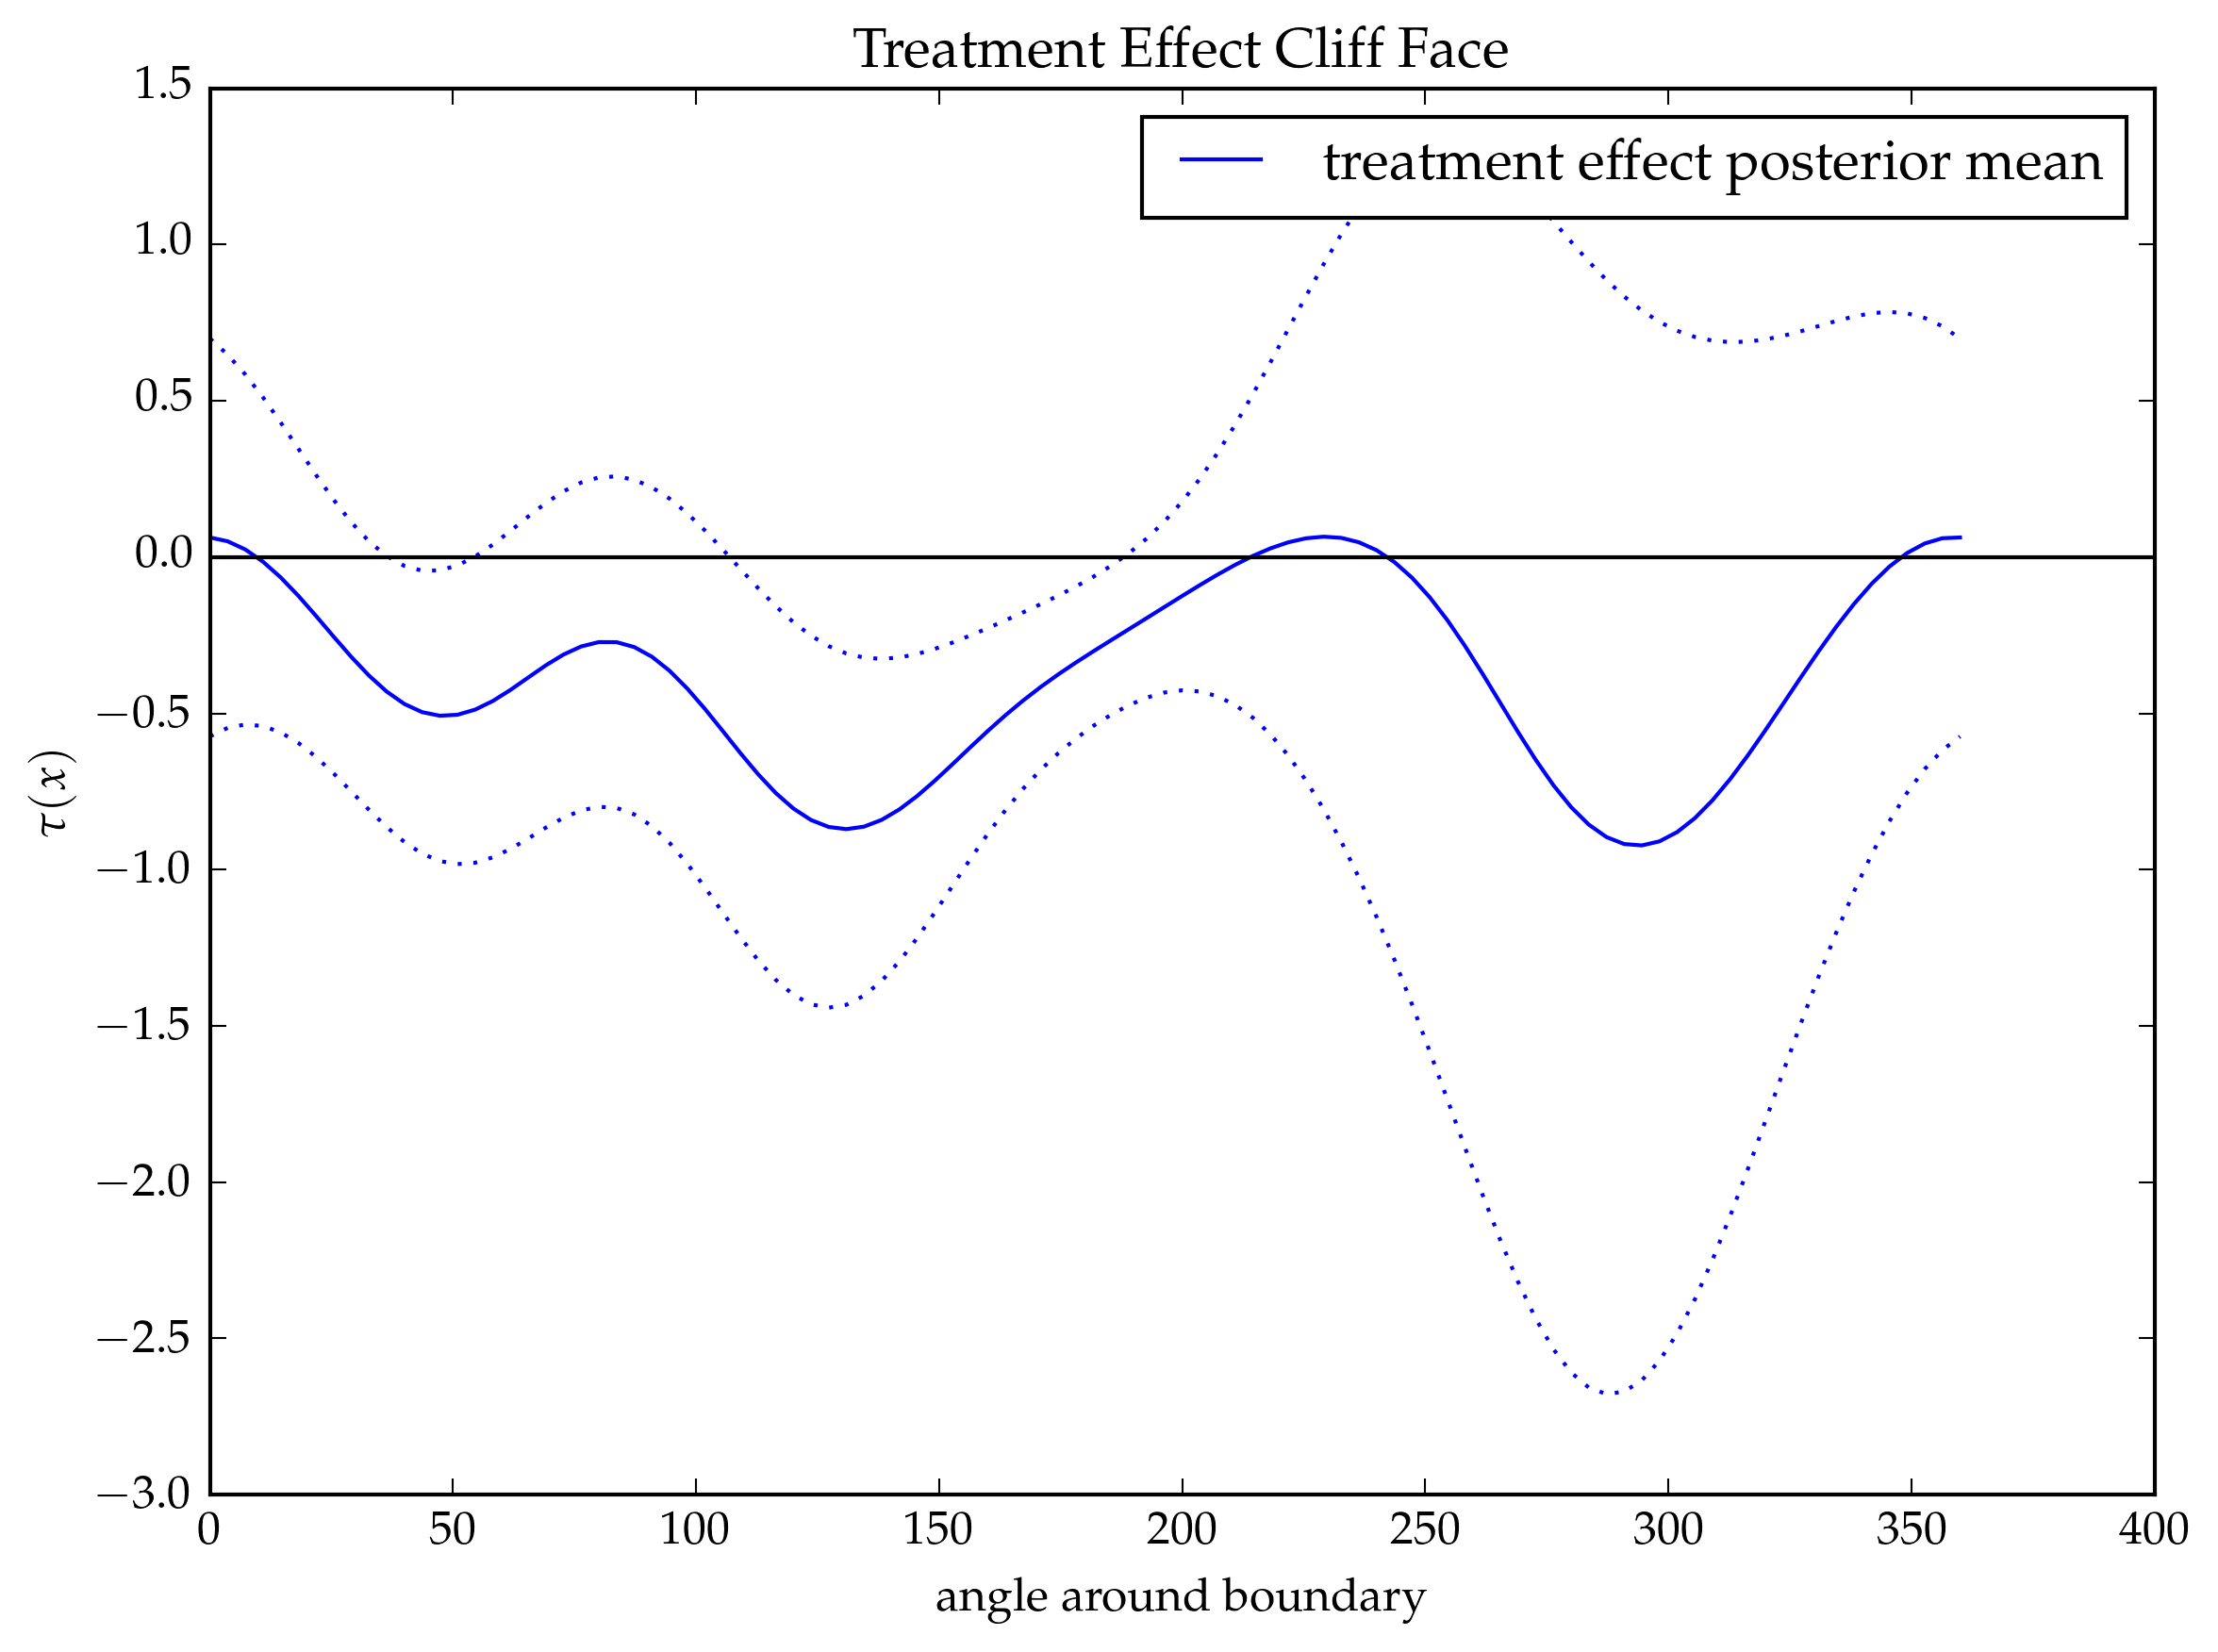

In [112]:
plt.plot(α◫*360/2π, μpost, color="blue", label="treatment effect posterior mean")
plt.plot(α◫*360/2π, μpost.+√diag(Σpost), color="blue", linestyle=":")
plt.plot(α◫*360/2π, μpost.-√diag(Σpost), color="blue", linestyle=":")
plt.axhline(y=0, color="black")
plt.title("Treatment Effect Cliff Face")
plt.ylabel(L"\tau(x)")
plt.xlabel("angle around boundary")
plt.legend()
;

# Estimate mean treatment effect

The output of the 2GP model is a posterior distribution of $\tau_\discont \mid Y,X$. Conveniently, because it is the difference of two GPs, the posterior of $\tau$ is itself a GP. Concretely, we evaluate it on a grid along the boundary, and so the posterior is normally distributed with mean $\mu^{post}$ and $\Sigma^{post}$. 

Let's think a little bit about estimands and estimators. Two possibilities occur to me:
## Distance-averaged treatment effect
The first idea is to just average the posterior treatment effect along the boundary. 
\begin{align}
    \tau &= \frac{\oint_\discont \left. \tau(x) dx \right.}{\oint_\discont \left. dx \right.} \\
    \hat{\tau} &= \frac{\oint_\discont \left. \tau(x \mid Y,X) dx \right.}{\oint_\discont \left. dx \right.} \\
    \E\hat{\tau} &\approx \frac{\sum_{j=1}^n \left. \mu^{post}_j \right.}{n} \\
        &= \ones_n^\intercal \mu^{post} / n\\
    \V\hat{\tau} &\approx \frac{\sum_{i=1}^n \sum_{j=1}^n \Sigma^{post}_{ij}}{n^2} \\
        &= \ones_n^\intercal  \Sigma^{post} \ones_n / n^2
\end{align}
This assumes the chosen grid along the boundary is evenly sampled. Otherwise, we need to account for the space occupied by each point. We would encode this with $\delta$, a vector of the lengths of the boundary occupied by each point in $X_\discont$, and we would get
\begin{align}
    \E\hat{\tau} &\approx \frac{\delta^\intercal \mu^{post}}{\delta^\intercal \ones_n} \\
    \V\hat{\tau} &\approx \frac{\delta^\intercal \Sigma^{post} \delta}{\delta^\intercal \delta}
\end{align}

In [102]:
τhat = sum(μpost)/n
Vτhat = sum(Σpost)/n^2
Normal(τhat, √Vτhat)

Distributions.Normal(μ=-0.13720526516201734, σ=0.16644142231053127)

In [114]:
1/sum(inv(Σpost))

0.016819134309259777

In [115]:
sum(Σpost)/n^2

0.027702747060752618

The problem with this is that the estimated variance $\V\hat{\tau}$ will blow up if there are sparsely populated segments of the boundary. It's the correct estimator for this estimand, but inference is essentially impossible if there are parts of the boundary where nobody lives (let's say the boundary goes through a big lake for example). This leads to the idea of downweighting the local treatment effects by their posterior variance.

## Inverse-variance weighted treatment effect
\begin{align}
    \E\hat{\tau} &= \frac{\ones_n^T \Sigma^{-1} \mu^{post}}{\ones_n^T \Sigma^{-1} \ones_n} \\
    \V\hat{\tau} &= \frac{\ones_n^T \Sigma^{-1} \ones_n}{\del{\ones_n^T \Sigma^{-1} \ones_n}^2} \\
    &= 1 \big/ \del{\ones_n^T \Sigma^{-1} \ones_n}
\end{align}

In [120]:
denom = sum(inv(Σpost))
τhat = sum(Σpost\μpost) / denom
Vτhat = 1/denom
Normal(τhat, √Vτhat)

Distributions.Normal(μ=-0.14340064666621105, σ=0.12968860516352151)

# Simulate under the null

Sensibly, since we are simulating from a null hypothesis, 0 is included in a 1$\sigma$ credible interval. Let's see how often that will be the case. To save ourselves some trouble, we'll keep the positions of the data fixed, so we can just simulate a new $Y$, thus leaving the covariance matrix unchanged.

In [131]:
function update_alpha!(gp::GP)
    m = GaussianProcesses.meanf(gp.m,gp.x)
    gp.alpha = gp.cK \ (gp.y - m)
end
type SimOutput
    τhat::Float64
    Vτhat::Float64
end
effsize(so::SimOutput) = so.τhat/√(Vτhat)

function sim_null()
    Ystar = rand(prior)
    gp_fit_inside.y = Ystar[inside]
    gp_fit_outside.y = Ystar[!inside]
    update_alpha!(gp_fit_inside)
    update_alpha!(gp_fit_outside)
    extrap◫_inside = predict(gp_fit_inside, X◫; full_cov=true)
    extrap◫_outside = predict(gp_fit_outside, X◫; full_cov=true)
    μpost = extrap◫_inside[1].-extrap◫_outside[1]
    Σpost = extrap◫_inside[2]+extrap◫_outside[2]
    denom = sum(inv(Σpost))
    
    # simple average, unweighted
    τhat = sum(μpost)/n
    Vτhat = sum(Σpost)/n^2
    unweighted = SimOutput(τhat, Vτhat)
    
    # inverse variance weighted
    τhat = sum(Σpost\μpost) / denom
    Vτhat = 1/denom
    invvariance = SimOutput(τhat, Vτhat)
    
    return unweighted, invvariance
end

eff_null = [sim_null() for _ in 1:10000];

In [132]:
all(Bool[sim[1].Vτhat >= sim[1].Vτhat for sim in eff_null])

true

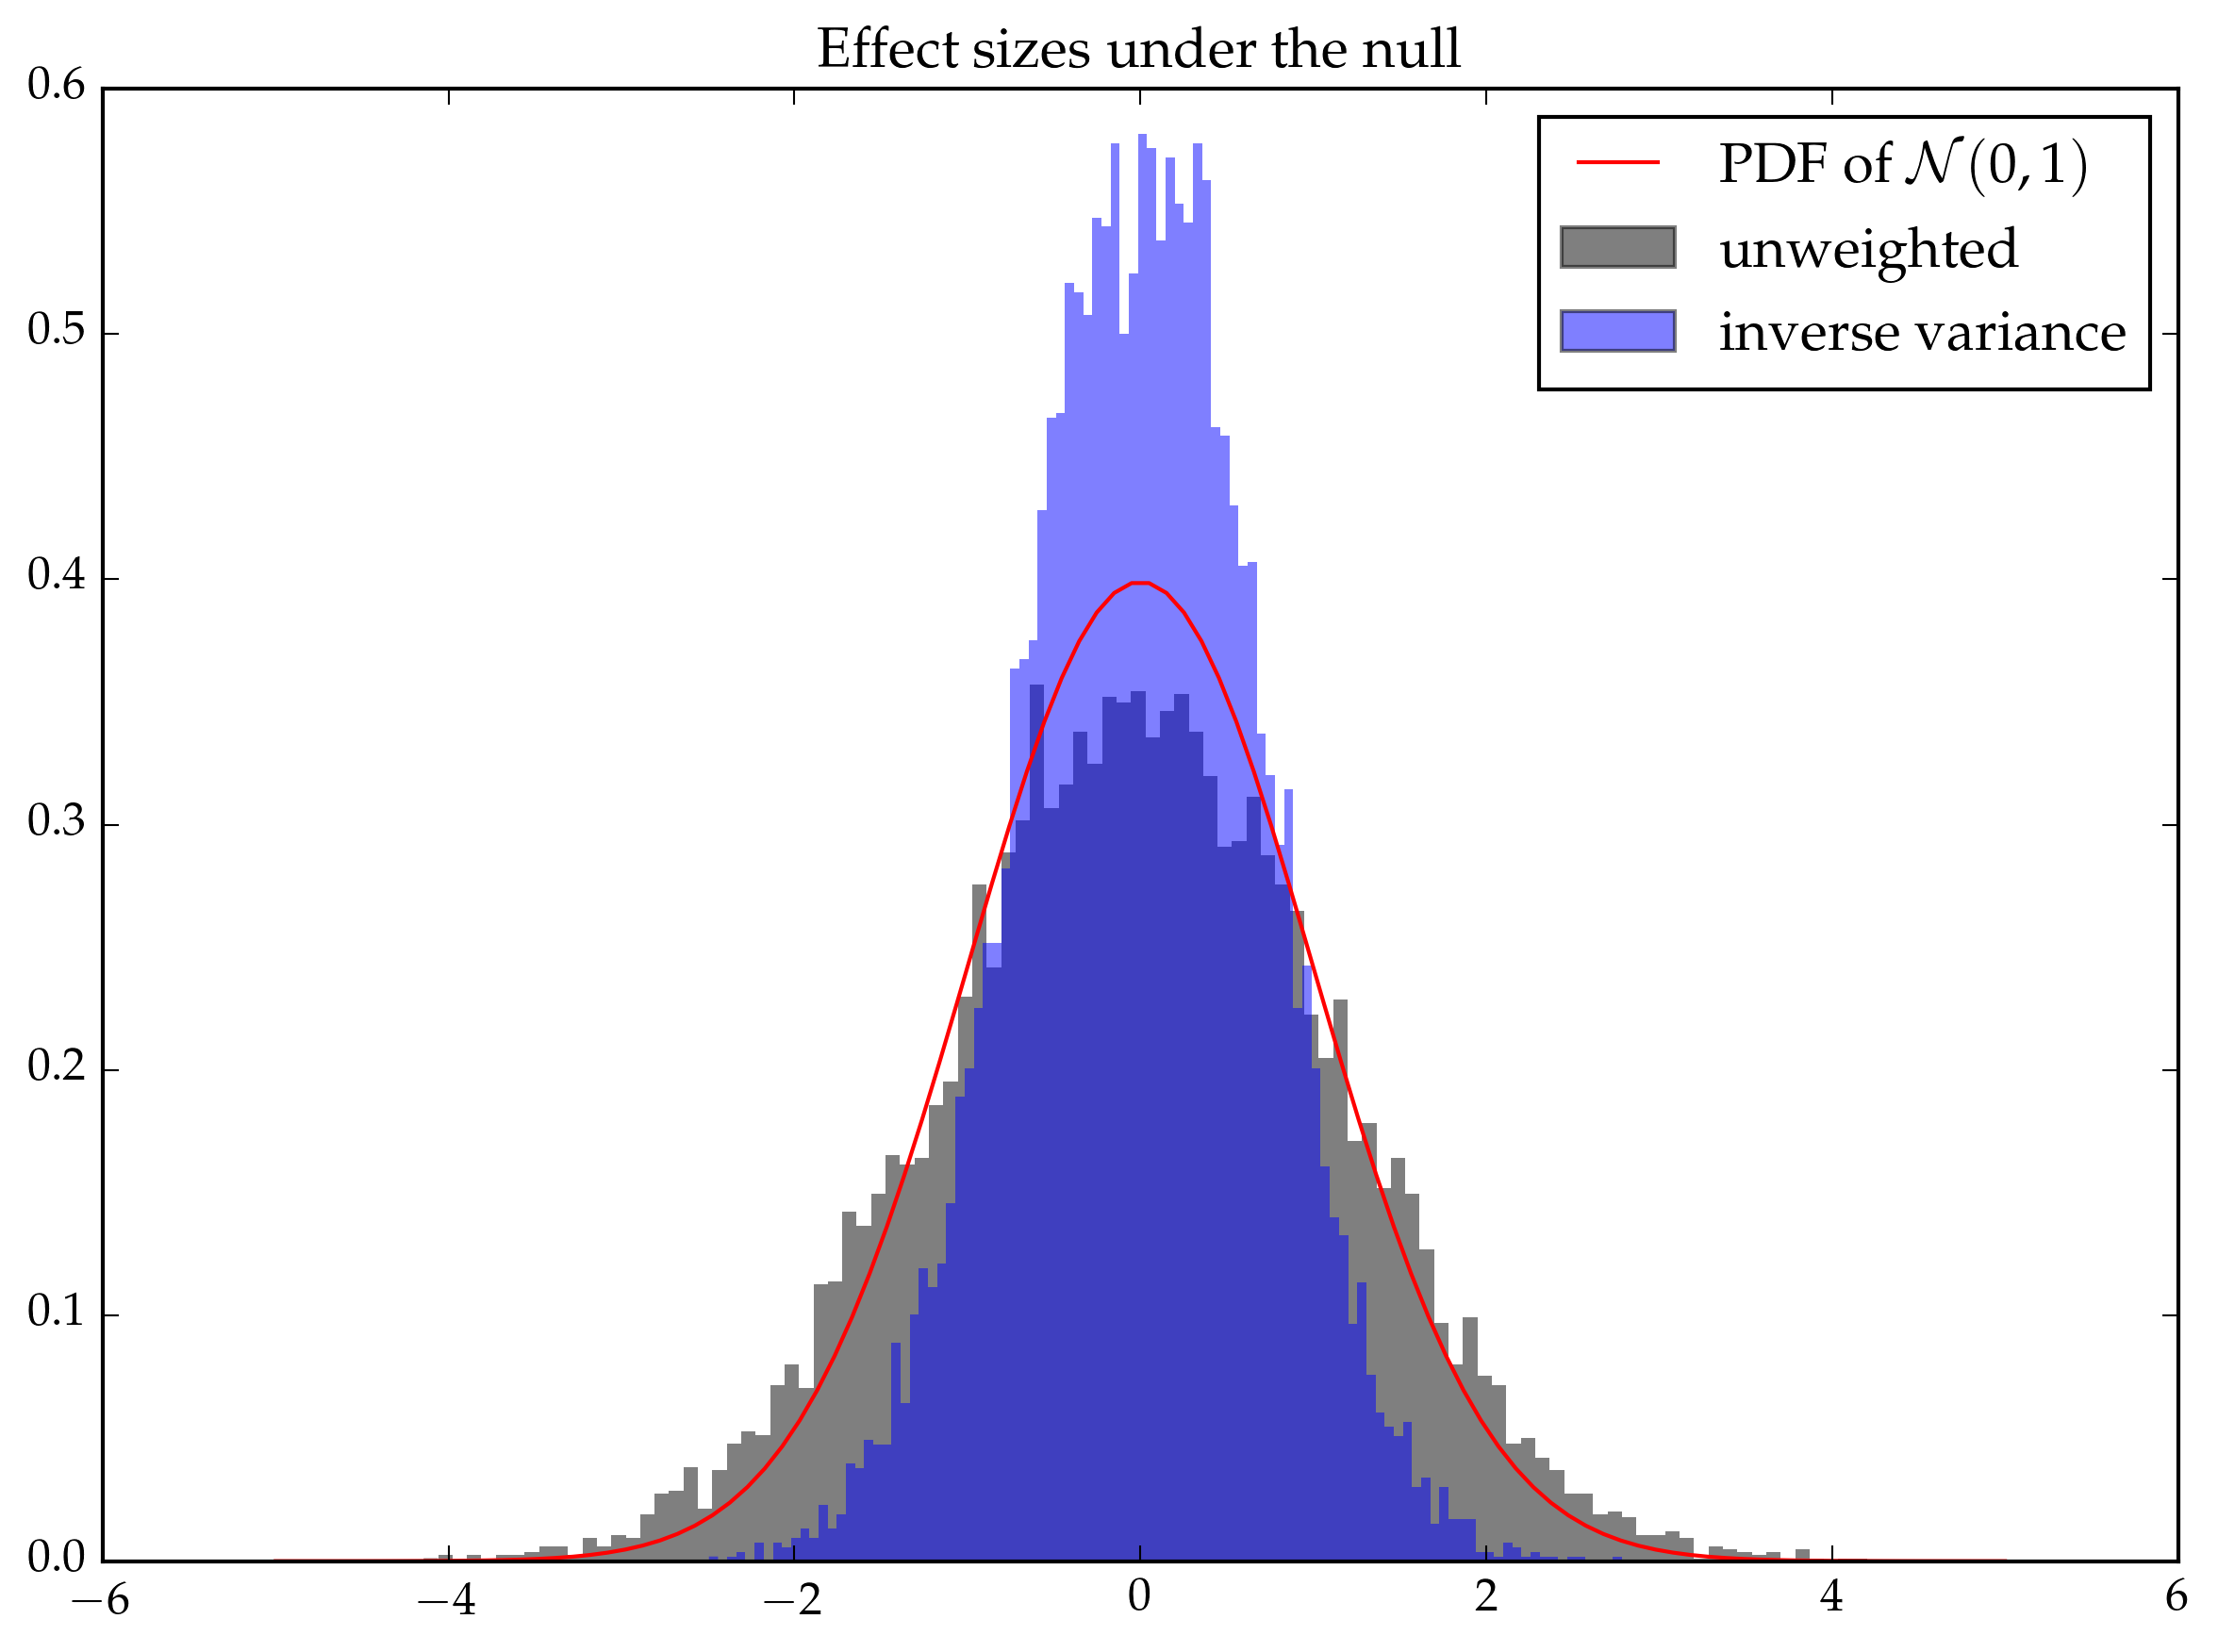

In [138]:
plt.plt[:hist](Float64[effsize(sim[1]) for sim in eff_null], 
        bins=100, color="black", alpha=0.5, edgecolor="none", normed=true, label="unweighted")
plt.plt[:hist](Float64[effsize(sim[2]) for sim in eff_null], 
        bins=100, color="blue", alpha=0.5, edgecolor="none", normed=true, label="inverse variance")
xx=linspace(-5.0,5.0,100)
plt.plot(xx, pdf(Normal(), xx), color="red", label=L"PDF of $\mathcal{N}(0,1)$")
plt.title("Effect sizes under the null")
plt.legend()
;

Interesting! The standardized effect $\E\hat{\tau} \big/ \sqrt{\V\hat{\tau}}$ is roughly a standard normal for both estimators. However, it has variance less than 1 for the inverse-variance estimator, and variance greater than 1 for the unweighted estimator.

# Power under an alternative

In [136]:
function sim_alt(τ::Float64)
    Ystar = rand(prior)
    Ystar[inside] .+= τ
    gp_fit_inside.y = Ystar[inside]
    gp_fit_outside.y = Ystar[!inside]
    update_alpha!(gp_fit_inside)
    update_alpha!(gp_fit_outside)
    extrap◫_inside = predict(gp_fit_inside, X◫; full_cov=true)
    extrap◫_outside = predict(gp_fit_outside, X◫; full_cov=true)
    μpost = extrap◫_inside[1].-extrap◫_outside[1]
    Σpost = extrap◫_inside[2]+extrap◫_outside[2]
    denom = sum(inv(Σpost))
    
    # simple average, unweighted
    τhat = sum(μpost)/n
    Vτhat = sum(Σpost)/n^2
    unweighted = SimOutput(τhat, Vτhat)
    
    # inverse variance weighted
    τhat = sum(Σpost\μpost) / denom
    Vτhat = 1/denom
    invvariance = SimOutput(τhat, Vτhat)
    
    return unweighted, invvariance
end
eff_alt = [sim_alt(0.5) for _ in 1:10000];

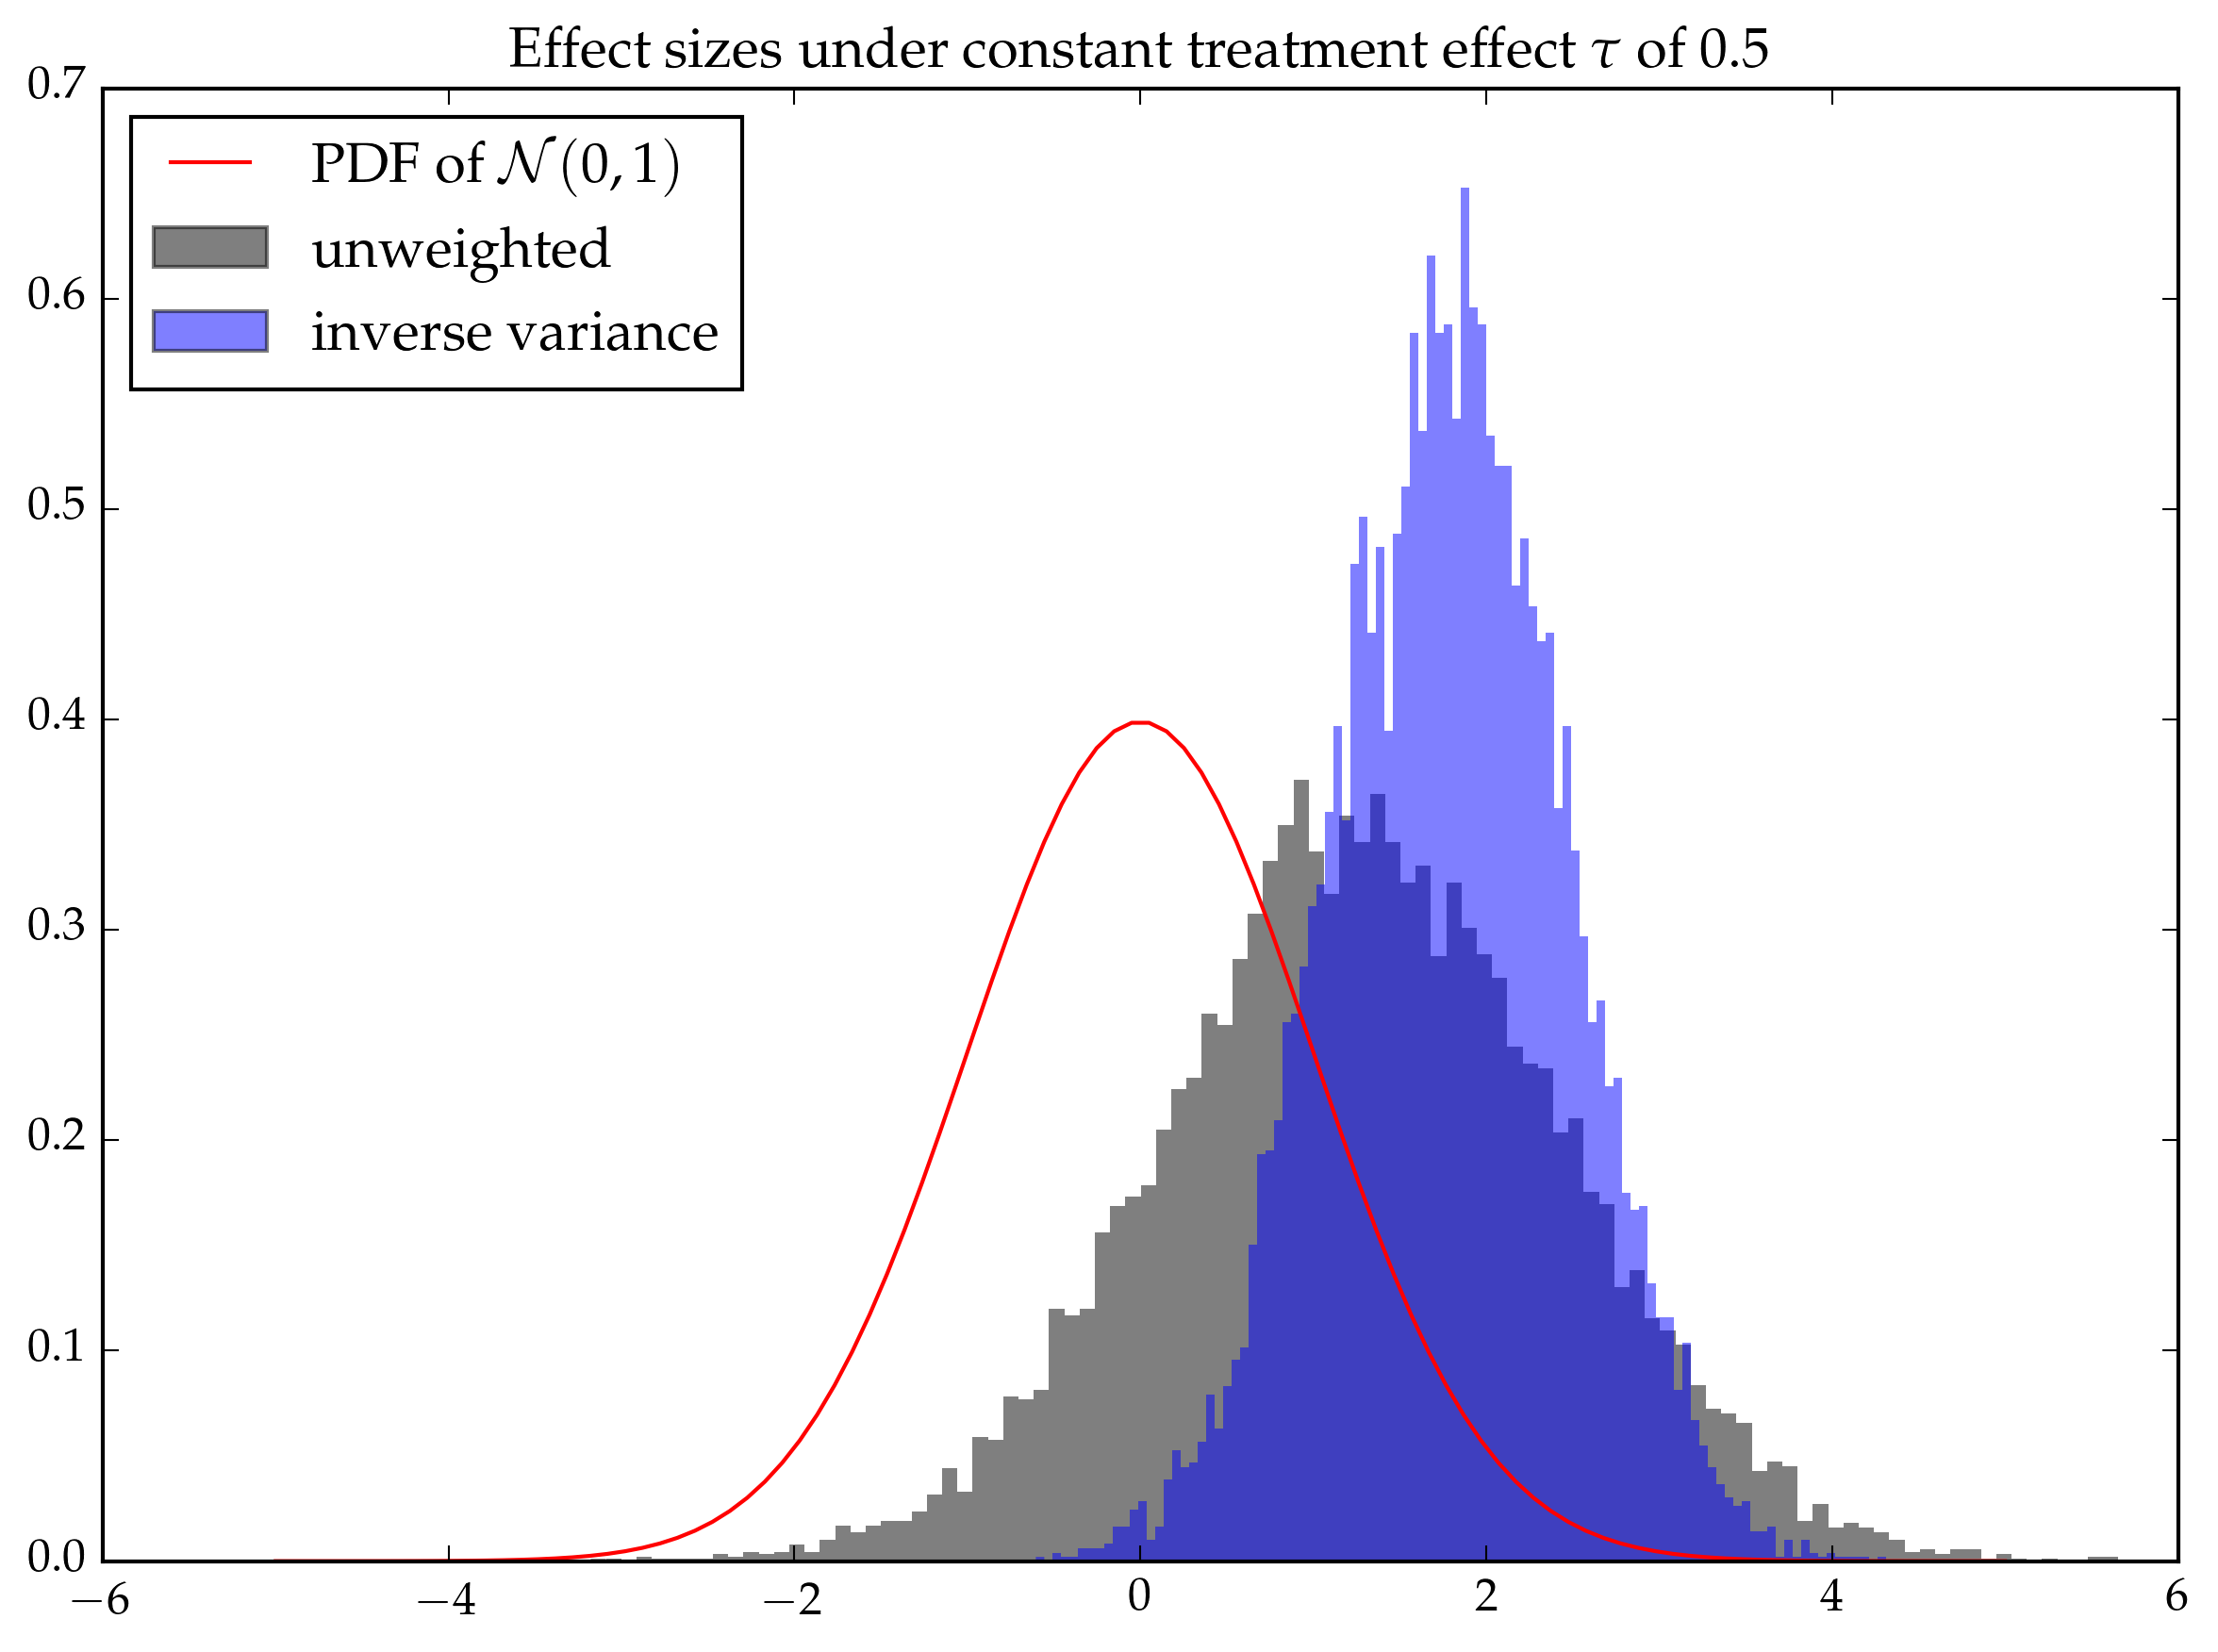

In [137]:
plt.plt[:hist](Float64[effsize(sim[1]) for sim in eff_alt], 
        bins=100, color="black", alpha=0.5, edgecolor="none", normed=true, label="unweighted")
plt.plt[:hist](Float64[effsize(sim[2]) for sim in eff_alt], 
        bins=100, color="blue", alpha=0.5, edgecolor="none", normed=true, label="inverse variance")
xx=linspace(-5.0,5.0,100)
plt.plot(xx, pdf(Normal(), xx), color="red", label=L"PDF of $\mathcal{N}(0,1)$")
plt.title(L"Effect sizes under constant treatment effect $\tau$ of 0.5")
plt.legend(loc="upper left")
;

Not too bad! This seems to be doing something sensible. It seems pretty clear that the inverse-variance estimator will have higher power to detect a constant effect like this.